In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob

from PIL import Image

#### Вспомогательные функции для отображения изображений

In [2]:
def show_images(images, n_rows=1, titles=None, figsize=(20, 20), cmap=None, xlabel=None, ylabel=None, axis=False):
    n_cols = len(images) // n_rows
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    titles = ['']*len(images) if titles is None else titles
    axes = axes.flatten()
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap=cmap)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.axis(axis)
    plt.show();
    
def show_image(image, to_rgb=False, title='', figsize=(20, 20), axis=False):
    
    img_c = image.copy()
    if to_rgb:
        img_c = cv2.cvtColor(img_c, cv2.COLOR_BGR2RGB)
        
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.axis(axis)
    plt.imshow(img_c)
    plt.show()
    
def imread_rgb(file):
    img  = cv2.imread(file, cv2.IMREAD_COLOR)
    assert img is not None, "file could not be read, check with os.path.exists()"
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [3]:
def yellow_filter(img):
    '''
    Функция выделяет желтык пиксели на изображении. 
    Используются значения из RGB диапазона.
    '''
    lower_ = np.array([190,155, 0])
    upper_ = np.array([255,220,130])
    mask = cv2.inRange(img, lower_, upper_)
    return cv2.bitwise_and(img, img, mask=mask), mask

def red_filter1(img):
    '''
    Функция выделяет красные пиксели на изображении. 
    Используются значения из RGB диапазона.
    '''
    lower_ = np.array([77,3,18])
    upper_ = np.array([250,128,128])
    mask = cv2.inRange(img, lower_, upper_)
    return cv2.bitwise_and(img, img, mask=mask), mask

def red_filter2(img):
    '''
    Функция выделяет красные пиксели на изображении. 
    Используются сравнение значений красного канала по отношению к остальным каналам.
    '''
    r, g, b = cv2.split(img)
    
    r1 = (r > 1.65*g).astype(np.uint8)
    r2 = (r > 1.65*b).astype(np.uint8)
    
    mask = cv2.bitwise_and(r1, r2)   
    return cv2.bitwise_and(img, img, mask=mask), mask

def color_filter(img):
    '''
    Функция для выделения красных и желтых пиксели на изображении. 
    '''
    _, mask_y = yellow_filter(img)
    _, mask_r = red_filter2(img)
    mask = cv2.bitwise_or(mask_y, mask_r)
    return cv2.bitwise_and(img, img, mask=mask), mask

#### Загрузим картинку с красным знаком и проверим функцию, которая выделяет красные пиксели на картинке.

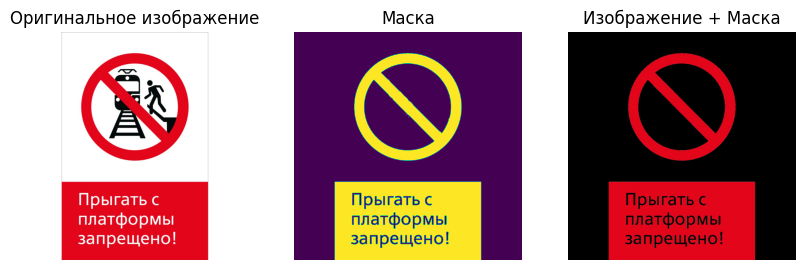

In [4]:
IMG_PATH = './warn_signs/red_0.jpg'
red_sign = imread_rgb(IMG_PATH)

filt, mask = red_filter2(red_sign)

titles = ['Оригинальное изображение', 'Маска', 'Изображение + Маска']
show_images([red_sign, mask, filt], figsize=(10, 10), titles=titles)

#### Повторим ту же операцию с желтым знаком.

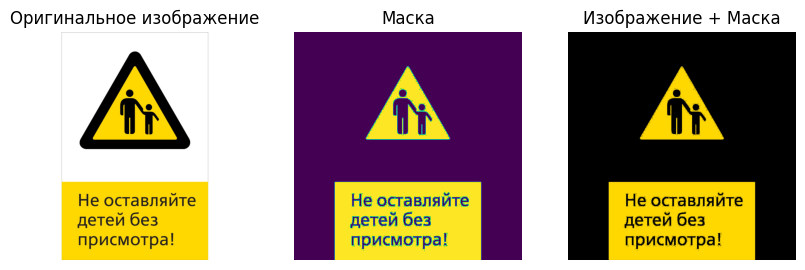

In [5]:
IMG_PATH = './warn_signs/yellow_0.jpg'

yellow_sign = imread_rgb(IMG_PATH)

filt, mask = yellow_filter(yellow_sign)
titles = ['Оригинальное изображение', 'Маска', 'Изображение + Маска']
show_images([yellow_sign, mask, filt], figsize=(10, 10), titles=titles)

#### Тест драйв на реальном изображении. Просто посмотреть.

In [6]:
IMG_PATH = './outdoors/yellow_near.jpg'

yellow_sign = imread_rgb(IMG_PATH)

filt, mask = color_filter(yellow_sign)
titles = ['Оригинальное изображение', 'Маска', 'Изображение + Маска']
show_images([yellow_sign, mask, filt], figsize=(10, 10), titles=titles)

In [7]:
def get_max_contour(mask):
    '''
    Получение наибольшего контура на изображении. 
    Предполагаем, что это будет прямоугольник с текстом.
    '''
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    max_area = 0
    max_contour = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > max_area:
            max_contour = contour
            max_area = area   
    
    return max_contour

def color_quad(img, visual_logging=False):
    '''
    1. Фильтрация цвета - находим область со знаком. 
    2. Применение операции дилатации для улучшения стабильности при поиске региона.
    3. Находим максимальный контур - наш прямоугольник с текстом.
    4. Извлекаем угловые точки контура
    '''
    filt, mask = color_filter(img)
        
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations = 1)
    
    max_contour = get_max_contour(mask)
    
    if visual_logging:
        cv2.drawContours(filt, [max_contour], 0, (255, 0, 0), 35)
        titles = ['Оригинальное изображение', 'Маска', 'Изображение + Маска']
        show_images([img, mask, filt], figsize=(10, 10), titles=titles)

    approx = cv2.approxPolyDP(max_contour, 0.02 * cv2.arcLength(max_contour, True), True)

    pts = np.float32([])
    if len(approx) == 4:
        points = []
        for i in range(4):
            points.append(approx[i][0])

        pts = np.float32(points)
    return pts

In [8]:
IMG_PATH = './warn_signs/yellow_1.jpg'

yellow_sign = imread_rgb(IMG_PATH)

#### Выделение прямоугольного контура (красным)

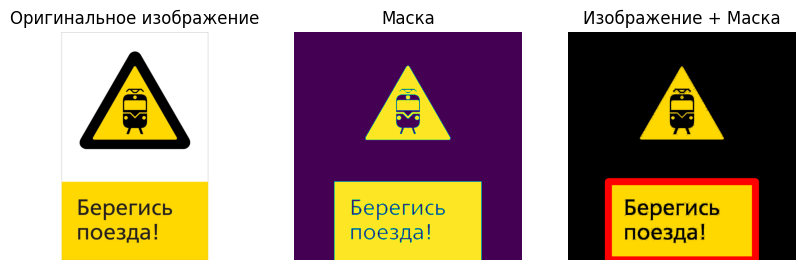

array([[ 212.,  787.],
       [ 212., 1199.],
       [ 986., 1199.],
       [ 986.,  787.]], dtype=float32)

In [9]:
color_quad(yellow_sign, visual_logging=True)

In [10]:
def eu_dist(pp, p2):
    '''
    Функция нахождения расстояния между двумя точками.
    '''
    return (p2[0]-pp[0])*(p2[0]-pp[0]) + (p2[1]-pp[1])*(p2[1]-pp[1]) 

def get_closest_point_to(pts, p2):
    '''
    Функция нахождения ближайшей точки из списка.
    '''
    pp = pts[0]
    d2 = eu_dist(pp, p2)
    
    for p in pts:
        d = eu_dist(p, p2)
        if d <= d2:
            pp = p
    return pp
      
def angle_between(p1, p2):
    '''
    Функция нахождения угла между двумя векторами. Нужна для сортировки точек.
    '''
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))

def get_center(pts):
    '''
    Функция нахождения центра в нашем прямоугольнике. Нужна для сортировки точек.
    '''
    cc = np.array([0,0])
    for p in pts:
        cc = cc + np.array(p)
    return cc * 0.25    

def sort2_byangle(pts):
    '''
    Функция сортировки точек. Необходимо для корректного афинного преобразования.
    '''
    cc = get_center(pts)
    dd = dict()
    for pp in pts:
        a = angle_between(cc, pp)    
        dd.update({a:pp})
    dict_srt = dict(sorted(dd.items()))
    
    srt = []
    for key, value in dict_srt.items():
        srt.append(value)
    return np.array(srt)

def get_ROI(arr, r):
    '''
    Функция вырезания из картинки определенного региона.
    '''
    return arr[r[1]:r[1]+r[3],r[0]:r[0]+r[2]]

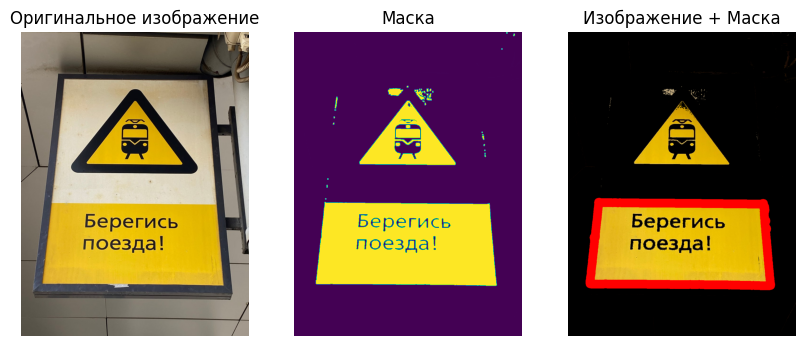

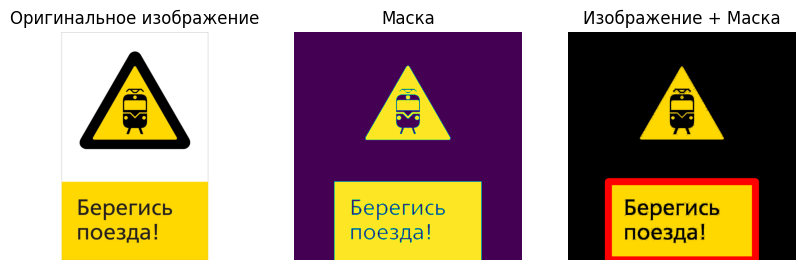

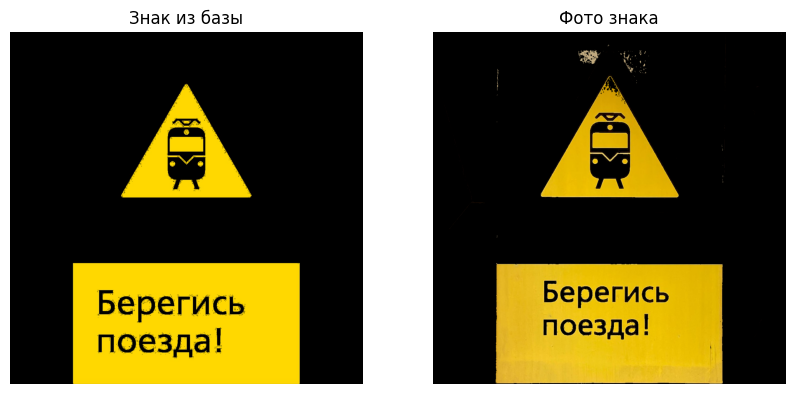

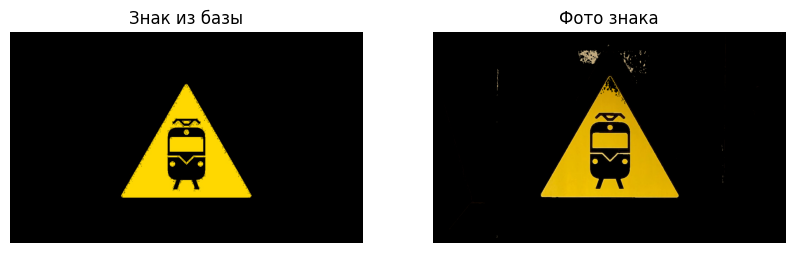

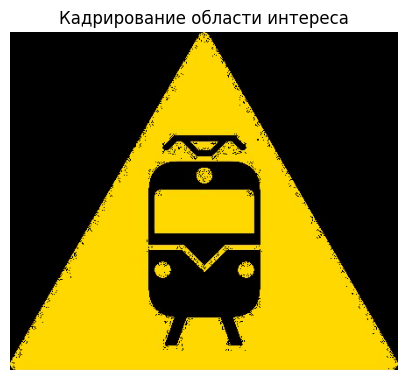

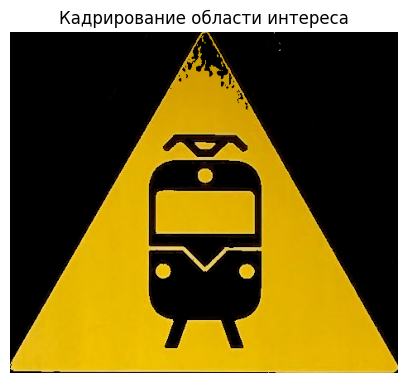

Процент схожести изображений - 0.9493499398231506


In [11]:
def get_uphalf(img):
    '''
    Функция оставляет только вернхнюю часть изображения. Там, где есть знак.
    '''
    shape2 = img.shape[:2]
    return img[0:shape2[0]*3//5, 0:shape2[1]]

def get_objimg(uphalf, visual_logging):
    '''
    Функция для кропа знака из изображения (на этом этапе это грубая верхняя часть).
    '''
    g1 = cv2.cvtColor(uphalf, cv2.COLOR_RGB2GRAY)

    _, thr1 = cv2.threshold(g1, 40, 255, cv2.THRESH_BINARY)
  
    up0_triangle = get_max_contour(thr1)

    up0_rect = cv2.boundingRect(up0_triangle)
    up0_roi = get_ROI(uphalf, up0_rect)
    
    if visual_logging:
        show_image(up0_roi, figsize=(5, 5), title='Кадрирование области интереса')
        
    return up0_roi

def draw_points_moving(src_img, src_pts, trg_img, trg_pts, img_size=(512, 512)):
    '''
    Функция для отображения точек перехода при афинном преобразовании.
    '''
    src_h, src_w = src_img.shape[:2]
    trg_h, trg_w = trg_img.shape[:2]
    img_h, img_w = img_size
    
    src_img, trg_img = [cv2.resize(x, (img_w, img_h)) for x in [src_img, trg_img]]
    out_img = np.hstack([src_img, trg_img])
    
    src_x_scale = img_w / src_w
    src_y_scale = img_h / src_h
    trg_x_scale = img_w / trg_w
    trg_y_scale = img_h / trg_h
    
    new_src_pts = [(int(x[0] * src_x_scale), int(x[1] * src_y_scale)) for x in src_pts]
    new_trg_pts = [(int(x[0] * trg_x_scale), int(x[1] * trg_y_scale)) for x in trg_pts]
    
    for (x1, y1), (x2, y2) in zip(new_src_pts, new_trg_pts):
        out_img = cv2.circle(out_img, (x1, y1), 5, (255, 0, 0), 10, 1)
        out_img = cv2.circle(out_img, (x2 + img_h, y2), 5, (0, 255, 0), 10, 1)
        out_img = cv2.arrowedLine(out_img, (x1, y1), (x2 + img_h, y2), (0, 0, 255), 3, 1, tipLength=0.03)
    
    return out_img

def recog_imgfile(imgfile, signfile, visual_logging=False):
    '''
    Итоговая функция для сравнения двух знаков на сходство.
    
    imgfile - путь до фотографии со знаком.
    signfile - путь до шаблона со знаком.
    '''
    img = imread_rgb(imgfile)
        
    pts = color_quad(img, visual_logging)
    pts = sort2_byangle(pts)
    
    img0 = imread_rgb(signfile)
    
    pts0 = color_quad(img0, visual_logging)
    pts0 = sort2_byangle(pts0)
    
    if len(pts) == 0 or len(pts0) == 0:
        return 0    
    
    if visual_logging:
        pm_img = draw_points_moving(img, pts, img0, pts0)
        show_image(pm_img, figsize=(10, 10), title='Точки для создания матрицы трансформации');
    
    M = cv2.getPerspectiveTransform(pts, pts0)
    dst = cv2.warpPerspective(img, M, (img0.shape[0], img0.shape[1]))
    
    if visual_logging:
        show_images([img, dst], figsize=(10, 10), titles=['Исходное изображение', 'Скорректированное изображение']);
    
    filt0, mask0 = color_filter(img0)
    filt_dst, mask_dst = color_filter(dst)

    if visual_logging:
        show_images([filt0, filt_dst], figsize=(10, 10), titles=['Знак из базы', 'Фото знака'])
    
    size = filt0.shape[:2]
    filt0_uphalf = get_uphalf(filt0)
    filt_dst_uphalf = get_uphalf(filt_dst)
    
    if visual_logging:
        show_images([filt0_uphalf, filt_dst_uphalf], figsize=(10, 10), titles=['Знак из базы', 'Фото знака'])

    sign0 = get_objimg(filt0_uphalf, visual_logging)    
    outdoor0 = get_objimg(filt_dst_uphalf, visual_logging)
    resized_outdoor = cv2.resize(outdoor0, (sign0.shape[1], sign0.shape[0]))
        
    xcc_normed_up = cv2.matchTemplate(sign0, resized_outdoor, cv2.TM_CCOEFF_NORMED)[0][0]
    return xcc_normed_up

#####
conf = recog_imgfile(
    './outdoors/yellow_near.jpg', 
    'warn_signs/yellow_1.jpg', 
    visual_logging=True,
)
print(f'Процент схожести изображений - {conf}')

In [12]:
def find_warnsign(sign_photo_path, templates_dir):
    '''
    Поиск и сравнение конкретного фото знака со всеми изображениями из папки.
    
    sign_photo_path - путь до фото со знаком.
    templates_dir - директория с шаблонами.
    '''
    sign_files = glob("warn_signs/*jpg")
      
    d_xcc = dict()
    for sign_template_path in sign_files:
        xcc = recog_imgfile(sign_photo_path, sign_template_path)
        d_xcc.update({xcc:sign_template_path})  
        print(sign_photo_path, "--->", sign_template_path, "=", xcc)

    
    d_srt = dict(sorted(d_xcc.items()))
    max_key = list(d_srt.keys())[-1]
    
    f_match = d_srt[max_key]
    print("xcc:", max_key, "template sign:", f_match)
    

    sgn = imread_rgb(f_match)
    photo = imread_rgb(sign_photo_path)
    
    show_images([photo, sgn], figsize=(10, 5), titles=['Фото', 'Максимально похожий знак'])
    
    return max_key

In [13]:
find_warnsign('./outdoors/yellow_far.jpg', "./warn_signs/")

./outdoors/yellow_far.jpg ---> warn_signs/yellow_0.jpg = 0.7036093
./outdoors/yellow_far.jpg ---> warn_signs/yellow_1.jpg = 0.9390423
./outdoors/yellow_far.jpg ---> warn_signs/red_0.jpg = -0.022691727
xcc: 0.9390423 template sign: warn_signs/yellow_1.jpg


0.9390423